# Analyzing neuropil signals in the mice
* 10/18/23 setup based on `Neuropil_analysis_single_exp.ipynb`
* adding dfof caluclation
* if dfof cal is used then i lose my effect. is it bc of the filterings implemented in dfof?
  

In [1]:
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from os.path import join
import pandas as pd
import scipy.signal as signal
from scipy import stats
import numpy as np

sys.path.append("/home/gergely/code/sleep/base/")

from suite2p_class import Suite2p
from mouse_class import Mouse
from eeg_class import eegData
from behavior_class import behaviorData
import dfof
import neuropil as nl


def freq_calc(data: pd.Series, fs: int = 10):
    """data: npil_eeg data"""
    frequencies, psd = signal.welch(data, fs=fs, detrend="linear")
    return frequencies, psd

In [2]:
sima_folders = [
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC1-001/TSeries-07072021-0833_GC1-001_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC2-003/TSeries-07072021-0833_GC2-003_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC1-002/TSeries-07072021-0833_MC1-002_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC2-004/TSeries-07072021-0833_MC2-004_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_GC-001/TSeries-07062021-0844_GC-001_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC-002/TSeries-07062021-0844_MC-002_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC2-004/TSeries-07062021-0844_MC2-004_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/sert52b_5/4_3_SD/TSeries-04032023-1323-001/TSeries-04032023-1323-001.sima",
    "/data2/gergely/invivo_DATA/sleep/sert54a_5/4_4/TSeries-04042023-1023_sess1-001/TSeries-04042023-1023_sess1-001.sima",
    "/data2/gergely/invivo_DATA/sleep/sert52b_1/4_3_SD/TSeries-04032023-1323_SD_sess1-001/TSeries-04032023-1323_SD_sess1-001.sima",
]

gcs = [
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC1-001/TSeries-07072021-0833_GC1-001_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC2-003/TSeries-07072021-0833_GC2-003_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_GC-001/TSeries-07062021-0844_GC-001_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/sert52b_5/4_3_SD/TSeries-04032023-1323-001/TSeries-04032023-1323-001.sima",
    "/data2/gergely/invivo_DATA/sleep/sert54a_5/4_4/TSeries-04042023-1023_sess1-001/TSeries-04042023-1023_sess1-001.sima",
    "/data2/gergely/invivo_DATA/sleep/sert52b_1/4_3_SD/TSeries-04032023-1323_SD_sess1-001/TSeries-04032023-1323_SD_sess1-001.sima",
]

mcs = [
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC1-002/TSeries-07072021-0833_MC1-002_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC2-004/TSeries-07072021-0833_MC2-004_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC-002/TSeries-07062021-0844_MC-002_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC2-004/TSeries-07062021-0844_MC2-004_Cycle00001_Element00001.sima",
]

In [4]:
# runs for about 6 minutes.

results = {}

for sima_folder in sima_folders:
    print(sima_folder)
    sima_dict = {}

    # Load eeg data
    file_name = join(sima_folder, "eeg", "velo_eeg.csv")
    eeg_velo = eegData.load_processed_velocity_eeg(file_name=file_name)
    eeg_velo["mobile_immobile"] = behaviorData.define_immobility(
        eeg_velo["filtered velo"]
    )
    df = eegData.brain_state_filter(
        velo_eeg_df=eeg_velo,
        states=["awake_mobile", "awake_immobile", "NREM", "REM", "other"],
    )

    s2p_folder = join(sima_folder, "suite2p")
    s2p_data = Suite2p(s2p_folder=s2p_folder)
    s2p_calc_dfof = dfof.Suite2pDFOF(window=1800)
    jia_calc_dfof = dfof.JiaDFOF(slow_trend_window=1800)

    # Calculate dfof
    cells = s2p_data.cells()
    npil = s2p_data.npil()
    cell_dfof = s2p_calc_dfof.calculate(signal=cells, npil=npil)
    npil_dfof = jia_calc_dfof.calculate(signal=npil)

    # Calculate mean dfof
    mean_cellF = cell_dfof.mean(axis=0)
    mean_npilF = npil_dfof.mean(axis=0)

    # Calculate freq and psd of cells
    awake_cell = pd.Series(mean_cellF[df["awake_immobile"]].values)
    awake_cell_freq, awake_cell_psd = freq_calc(awake_cell)
    sima_dict["awake_cell"] = {
        "freq": awake_cell_freq,
        "psd": awake_cell_psd,
        "mean_ca": awake_cell,
    }

    nrem_cell = pd.Series(mean_cellF[df["NREM"]].values)
    nrem_cell_freq, nrem_cell_psd = freq_calc(nrem_cell)
    sima_dict["nrem_cell"] = {
        "freq": nrem_cell_freq,
        "psd": nrem_cell_psd,
        "mean_ca": nrem_cell,
    }

    # Calculate freq and psd of npil
    awake_immobile_npil = pd.Series(mean_npilF[df["awake_immobile"]].values)
    awake_immobile_npil_freq, awake_immobile_npil_psd = freq_calc(awake_immobile_npil)
    sima_dict["awake_immobile_npil"] = {
        "freq": awake_immobile_npil_freq,
        "psd": awake_immobile_npil_psd,
        "mean_ca": awake_immobile_npil,
    }

    nrem_npil = pd.Series(mean_npilF[df["NREM"]].values)
    nrem_npil_freq, nrem_npil_psd = freq_calc(nrem_npil)
    sima_dict["nrem_npil"] = {
        "freq": nrem_npil_freq,
        "psd": nrem_npil_psd,
        "mean_ca": nrem_npil,
    }

    results[sima_folder] = sima_dict

/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC1-001/TSeries-07072021-0833_GC1-001_Cycle00001_Element00001.sima
Calculating slow trend
/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC2-003/TSeries-07072021-0833_GC2-003_Cycle00001_Element00001.sima
Calculating slow trend
/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC1-002/TSeries-07072021-0833_MC1-002_Cycle00001_Element00001.sima
Calculating slow trend
/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC2-004/TSeries-07072021-0833_MC2-004_Cycle00001_Element00001.sima
Calculating slow trend
/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_GC-001/TSeries-07062021-0844_GC-001_Cycle00001_Element00001.sima
Calculating slow trend
/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC-002/TSeries-07062021-0844_MC-002_Cycle00001_Element00001.sima
Calculating slow trend
/data2/gergely

In [ ]:
results_df = pd.DataFrame(results)
results_df

Saving the results to h5 file

In [29]:
from os import path


with pd.HDFStore("results.h5") as store:
    for col in results_df.columns:
        for idx, cell in enumerate(results_df[col]):
            if isinstance(cell, dict) and all(
                isinstance(cell[key], np.ndarray) for key in ["freq", "psd", "mean_ca"]
            ):
                # Create a path in HDF5 to save the arrays
                path_freq = f"{col}/{idx}/freq"
                path_psd = f"{col}/{idx}/psd"
                path_mean_ca = f"{col}/{idx}/mean_ca"

                # Save the numpy arrays to the respective paths
                store.put(path_freq, pd.Series(cell["freq"]))
                store.put(path_psd, pd.Series(cell["psd"]))
                store.put(path_mean_ca, pd.Series(cell["mean_ca"]))

                # Replace the cell content with the reference to the paths
                results_df.at[idx, col] = {
                    "freq": path_freq,
                    "psd": path_psd,
                    "mean_ca": path_mean_ca,
                }

# Now, save the main DataFrame which contains paths to the arrays instead of the actual arrays
results_df.to_hdf("results.h5", key="main_df", mode="a")

/tmp/ipykernel_18245/2972934700.py:28: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC1-001/TSeries-07072021-0833_GC1-001_Cycle00001_Element00001.sima',
       '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC2-003/TSeries-07072021-0833_GC2-003_Cycle00001_Element00001.sima',
       '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC1-002/TSeries-07072021-0833_MC1-002_Cycle00001_Element00001.sima',
       '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC2-004/TSeries-07072021-0833_MC2-004_Cycle00001_Element00001.sima',
       '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_GC-001/TSeries-07062021-0844_GC-001_Cycle00001_Element00001.sima',
       '/data2/gergely/inviv

#### loading the data from file

In [2]:
results_df = nl.load_results("results.h5")
results_df

,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC1-001/TSeries-07072021-0833_GC1-001_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC2-003/TSeries-07072021-0833_GC2-003_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC1-002/TSeries-07072021-0833_MC1-002_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC2-004/TSeries-07072021-0833_MC2-004_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_GC-001/TSeries-07062021-0844_GC-001_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC-002/TSeries-07062021-0844_MC-002_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC2-004/TSeries-07062021-0844_MC2-004_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/sert52b_5/4_3_SD/TSeries-04032023-1323-001/TSeries-04032023-1323-001.sima,/data2/gergely/invivo_DATA/sleep/sert54a_5/4_4/TSeries-04042023-1023_sess1-001/TSeries-04042023-1023_sess1-001.sima,/data2/gergely/invivo_DATA/sleep/sert52b_1/4_3_SD/TSeries-04032023-1323_SD_sess1-001/TSeries-04032023-1323_SD_sess1-001.sima
awake_cell,"{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,..."
nrem_cell,"{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,..."
awake_immobile_npil,"{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,..."
nrem_npil,"{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,..."


In [ ]:
# This does not work, because the arrays are not the same lenght
# 1. Extract PSD arrays
ca_df = results_df.applymap(
    lambda d: d["mean_ca"] if isinstance(d, dict) and "mean_ca" in d else np.nan
)
ca_df
# 2. Calculate the Mean of arrays
ca_mean = ca_df.apply(
    lambda col: np.mean(np.vstack(col.dropna().values[:20]), axis=1), axis=1
)

ca_mean

In [3]:
# 1. Extract PSD arrays
psd_df = results_df.applymap(
    lambda d: d["psd"] if isinstance(d, dict) and "psd" in d else np.nan
)
psd_df

,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC1-001/TSeries-07072021-0833_GC1-001_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC2-003/TSeries-07072021-0833_GC2-003_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC1-002/TSeries-07072021-0833_MC1-002_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC2-004/TSeries-07072021-0833_MC2-004_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_GC-001/TSeries-07062021-0844_GC-001_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC-002/TSeries-07062021-0844_MC-002_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC2-004/TSeries-07062021-0844_MC2-004_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/sert52b_5/4_3_SD/TSeries-04032023-1323-001/TSeries-04032023-1323-001.sima,/data2/gergely/invivo_DATA/sleep/sert54a_5/4_4/TSeries-04042023-1023_sess1-001/TSeries-04042023-1023_sess1-001.sima,/data2/gergely/invivo_DATA/sleep/sert52b_1/4_3_SD/TSeries-04032023-1323_SD_sess1-001/TSeries-04032023-1323_SD_sess1-001.sima
awake_cell,"[0.0002650830269505628, 0.0011871280923661514,...","[0.00014827020285672633, 0.0004773922969329735...","[0.0009275290543216832, 0.0035331081664132366,...","[0.0008419426170684678, 0.0034818030811394896,...","[0.00028820984531770634, 0.0009103013073193828...","[0.0008169235389835857, 0.0034735892901080543,...","[0.0007473489807310762, 0.00308158271474358, 0...","[0.00025884303661127925, 0.0008631185698337565...","[6.318930441117312e-05, 0.00022485645975660313...","[0.0002025313784776067, 0.0006011439964505426,..."
nrem_cell,"[0.0003447960700684298, 0.0011182951621838326,...","[7.044842973382416e-05, 0.0002869383539443003,...","[0.00032676198235586615, 0.0011615961254917507...","[0.0007235043574949551, 0.0025875645044527206,...","[0.00012939909481732336, 0.0005043804871930188...","[0.0004544318868549393, 0.0016847706150976468,...","[0.0017906980480981184, 0.0057153155933431675,...","[0.000474815052390608, 0.00138437560822615, 0....","[9.779264471311636e-05, 0.00031948083455534353...","[0.00014873167631425515, 0.0005526459015741937..."
awake_immobile_npil,"[0.0002662342997144074, 0.0037399182477307657,...","[0.0008945962118178542, 0.0026180369194614634,...","[0.0005941078876217715, 0.002765329714194301, ...","[0.0011806240684124989, 0.004519537263746857, ...","[0.000666819149573295, 0.0022617729877869616, ...","[0.0007497072575121578, 0.0028063299585032323,...","[0.0012731939553333811, 0.005290998218856839, ...","[0.0033468792172972857, 0.012481740968327527, ...","[0.00020348135323519637, 0.0006142616713094906...","[0.0021849704474003807, 0.005195327113945941, ..."
nrem_npil,"[0.00028671855830200433, 0.0013670489175098021...","[0.000988720863042025, 0.004641034098213896, 0...","[0.000577161989810425, 0.0024093589938276086, ...","[0.0032000133365728462, 0.012585788632554315, ...","[0.000388229172900373, 0.0016206452957911485, ...","[0.0006246888838389134, 0.003005702273268296, ...","[0.007341257650822803, 0.022788573421577214, 0...","[0.004466305559407752, 0.015443592833985897, 0...","[0.00011280849120151793, 0.0003869056821915992...","[0.00188860795152543, 0.00557485771491592, 0.0..."


<Axes: title={'center': 'Npil'}, xlabel='Frequency (Hz)', ylabel='Power/Frequency (dB/Hz)'>

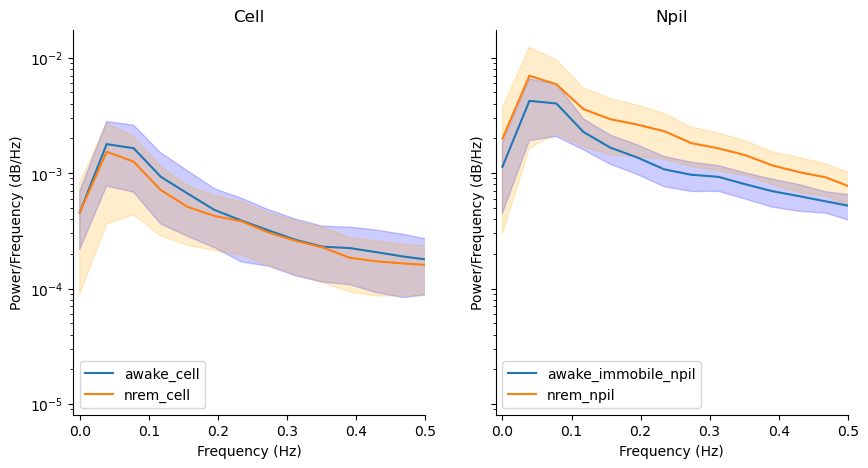

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)

nl.spectral_density_plot(psd_df, ["awake_cell", "nrem_cell"], ax=ax[0])
nl.spectral_density_plot(
    psd_df, ["awake_immobile_npil", "nrem_npil"], ax=ax[1], labels={"title": "Npil"}
)

(-0.1, 0.5)

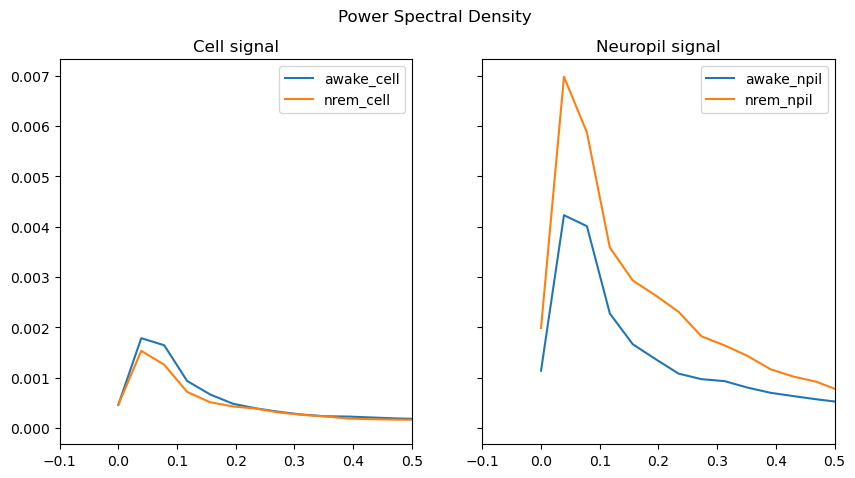

In [7]:
# plot with linear y axis:

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True, sharex=True)
fig.suptitle("Power Spectral Density")

x = results_df.iloc[0][0]["freq"]
axs[0].plot(x, psd_df.loc["awake_cell"].mean(), label="awake_cell")
axs[0].plot(x, psd_df.loc["nrem_cell"].mean(), label="nrem_cell")
axs[0].legend()
axs[0].title.set_text("Cell signal")

axs[1].plot(x, psd_df.loc["awake_immobile_npil"].mean(), label="awake_npil")
axs[1].plot(x, psd_df.loc["nrem_npil"].mean(), label="nrem_npil")
axs[1].legend()
axs[1].title.set_text("Neuropil signal")

plt.xlim(-0.1, 0.5)
# fig.savefig("psd.png")

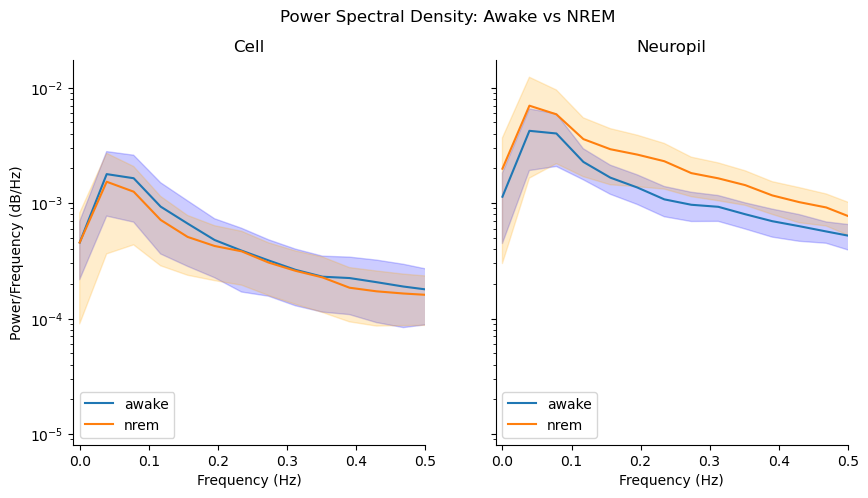

In [10]:
# plotting with log y axis:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)
fig.suptitle("Power Spectral Density: Awake vs NREM")
freq = results_df.iloc[0][0]["freq"]
# Calculate the standard error of the mean (SEM) for confidence intervals
awake_cell_mean = psd_df.loc["awake_cell"].mean()
awake_cell_sem = stats.sem(psd_df.loc["awake_cell"], axis=0, nan_policy="omit")

nrem_cell_mean = psd_df.loc["nrem_cell"].mean()
nrem_cell_sem = stats.sem(psd_df.loc["nrem_cell"], axis=0, nan_policy="omit")

# Calculate the confidence interval
confidence = 0.95  # for a 95% confidence interval
ci = stats.t.ppf((1 + confidence) / 2.0, len(psd_df.loc["awake_cell"]) - 1)

awake_cell_lower = awake_cell_mean - ci * awake_cell_sem
awake_cell_upper = awake_cell_mean + ci * awake_cell_sem

nrem_cell_lower = nrem_cell_mean - ci * nrem_cell_sem
nrem_cell_upper = nrem_cell_mean + ci * nrem_cell_sem

# Plot the means with semilogy
axs[0].semilogy(freq, awake_cell_mean, label="awake")
axs[0].semilogy(freq, nrem_cell_mean, label="nrem")
axs[0].legend(loc="lower left")
axs[0].set_title("Cell")
axs[0].set_xlabel("Frequency (Hz)")
axs[0].set_ylabel("Power/Frequency (dB/Hz)")

# Plot the confidence intervals with fill_between
axs[0].fill_between(freq, awake_cell_lower, awake_cell_upper, color="blue", alpha=0.2)
axs[0].fill_between(freq, nrem_cell_lower, nrem_cell_upper, color="orange", alpha=0.2)
axs[0].set_xlim(-0.01, 0.5)
axs[0].spines["top"].set_visible(False)
axs[0].spines["right"].set_visible(False)

awake_immobile_npil_mean = psd_df.loc["awake_immobile_npil"].mean()
awake_immobile_npil_sem = stats.sem(
    psd_df.loc["awake_immobile_npil"], axis=0, nan_policy="omit"
)

nrem_npil_mean = psd_df.loc["nrem_npil"].mean()
nrem_npil_sem = stats.sem(psd_df.loc["nrem_npil"], axis=0, nan_policy="omit")

# Calculate the confidence interval
confidence = 0.95  # for a 95% confidence interval
ci = stats.t.ppf((1 + confidence) / 2.0, len(psd_df.loc["awake_immobile_npil"]) - 1)

awake_npil_lower = awake_immobile_npil_mean - ci * awake_immobile_npil_sem
awake_npil_upper = awake_immobile_npil_mean + ci * awake_immobile_npil_sem

nrem_npil_lower = nrem_npil_mean - ci * nrem_npil_sem
nrem_npil_upper = nrem_npil_mean + ci * nrem_npil_sem


axs[1].semilogy(freq, psd_df.loc["awake_immobile_npil"].mean(), label="awake")
axs[1].semilogy(freq, psd_df.loc["nrem_npil"].mean(), label="nrem")

axs[1].fill_between(freq, awake_npil_lower, awake_npil_upper, color="blue", alpha=0.2)
axs[1].fill_between(freq, nrem_npil_lower, nrem_npil_upper, color="orange", alpha=0.2)

axs[1].legend(loc="lower left")
axs[1].set_title("Neuropil")
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_xlim(-0.01, 0.5)
axs[1].spines["top"].set_visible(False)
axs[1].spines["right"].set_visible(False)

# fig.savefig("cell npil psd plot.png")

In [13]:
cell_results = {}
npil_results = {}

for sima_folder in sima_folders:
    ##### Data loading and setup
    cell_dict = {}
    npil_dict = {}
    file_name = join(sima_folder, "eeg", "velo_eeg.csv")
    eeg_velo = eegData.load_processed_velocity_eeg(file_name=file_name)
    eeg_velo["mobile_immobile"] = behaviorData.define_immobility(
        eeg_velo["filtered velo"]
    )
    df = eegData.brain_state_filter(
        velo_eeg_df=eeg_velo,
        states=["awake_mobile", "awake_immobile", "NREM", "REM", "other"],
    )
    s2p_folder = join(sima_folder, "suite2p")

    ##### Cell calculation
    s2p_data = Suite2p(s2p_folder=s2p_folder)
    s2p_calc_dfof = dfof.Suite2pDFOF(window=1800)
    jia_calc_dfof = dfof.JiaDFOF(slow_trend_window=1800)

    # Calculate dfof
    cells = s2p_data.cells()
    npil = s2p_data.npil()
    cell_dfof = s2p_calc_dfof.calculate(signal=cells, npil=npil)

    mean_cellF = cell_dfof.mean(axis=0)

    awake_cell = pd.Series(mean_cellF[df["awake_immobile"]].values)
    awake_cell_freq, awake_cell_psd = freq_calc(awake_cell)
    cell_dict["cell_awake_freq"] = {"freq": awake_cell_freq}
    cell_dict["cell_awake_psd"] = {"psd": awake_cell_psd}
    cell_dict["cell_awake_Ca"] = {"mean_ca": awake_cell}

    nrem_cell = pd.Series(mean_cellF.loc[df["NREM"]].values)
    nrem_cell_freq, nrem_cell_psd = freq_calc(nrem_cell)
    cell_dict["cell_nrem_freq"] = {"freq": nrem_cell_freq}
    cell_dict["cell_nrem_psd"] = {"psd": nrem_cell_psd}
    cell_dict["cell_nrem_Ca"] = {"mean_ca": nrem_cell}

    cell_results[sima_folder] = cell_dict

    ##### Neuropil calculation

    npil_dfof = jia_calc_dfof.calculate(signal=npil)
    mean_npilF = npil_dfof.mean(axis=0)

    awake_immobile_npil = pd.Series(mean_npilF.loc[df["awake_immobile"]].values)
    awake_immobile_npil_freq, awake_immobile_npil_psd = freq_calc(awake_immobile_npil)
    npil_dict["npil_awake_freq"] = ({"freq": awake_immobile_npil_freq},)
    npil_dict["npil_awake_psd"] = {"psd": awake_immobile_npil_psd}
    npil_dict["npil_awake_Ca"] = {"mean_ca": awake_immobile_npil}

    nrem_npil = pd.Series(mean_npilF.loc[df["NREM"]].values)
    nrem_npil_freq, nrem_npil_psd = freq_calc(nrem_npil)
    npil_dict["npil_nrem_freq"] = {"freq": nrem_npil_freq}
    npil_dict["npil_nrem_psd"] = {"psd": nrem_npil_psd}
    npil_results[sima_folder] = npil_dict

Calculating slow trend
Calculating slow trend
Calculating slow trend
Calculating slow trend
Calculating slow trend
Calculating slow trend
Calculating slow trend
Calculating slow trend
Calculating slow trend
Calculating slow trend


In [14]:
cell_results_df = pd.DataFrame(cell_results)
npil_results_df = pd.DataFrame(npil_results)

In [15]:
cell_df = cell_results_df.copy()
cell_awake_arrs = []
cell_nrem_arrs = []
for i in range(len(cell_df.columns)):
    cell_awake_arrs.append(cell_df.loc["cell_awake_psd"][i]["psd"])
    cell_nrem_arrs.append(cell_df.loc["cell_nrem_psd"][i]["psd"])
cell_awake_mean_freq = np.mean(cell_awake_arrs, axis=0)
cell_nrem_mean_freq = np.mean(cell_nrem_arrs, axis=0)

npil_df = npil_results_df.copy()
npil_awake_arrs = []
npil_nrem_arrs = []
for i in range(len(npil_df.columns)):
    npil_awake_arrs.append(npil_df.loc["npil_awake_psd"][i]["psd"])
    npil_nrem_arrs.append(npil_df.loc["npil_nrem_psd"][i]["psd"])
npil_awake_mean_freq = np.mean(npil_awake_arrs, axis=0)
npil_nrem_mean_freq = np.mean(npil_nrem_arrs, axis=0)

In [16]:
npil_df.loc["npil_awake_freq"][0][0]["freq"]

array([0.       , 0.0390625, 0.078125 , 0.1171875, 0.15625  , 0.1953125,
       0.234375 , 0.2734375, 0.3125   , 0.3515625, 0.390625 , 0.4296875,
       0.46875  , 0.5078125, 0.546875 , 0.5859375, 0.625    , 0.6640625,
       0.703125 , 0.7421875, 0.78125  , 0.8203125, 0.859375 , 0.8984375,
       0.9375   , 0.9765625, 1.015625 , 1.0546875, 1.09375  , 1.1328125,
       1.171875 , 1.2109375, 1.25     , 1.2890625, 1.328125 , 1.3671875,
       1.40625  , 1.4453125, 1.484375 , 1.5234375, 1.5625   , 1.6015625,
       1.640625 , 1.6796875, 1.71875  , 1.7578125, 1.796875 , 1.8359375,
       1.875    , 1.9140625, 1.953125 , 1.9921875, 2.03125  , 2.0703125,
       2.109375 , 2.1484375, 2.1875   , 2.2265625, 2.265625 , 2.3046875,
       2.34375  , 2.3828125, 2.421875 , 2.4609375, 2.5      , 2.5390625,
       2.578125 , 2.6171875, 2.65625  , 2.6953125, 2.734375 , 2.7734375,
       2.8125   , 2.8515625, 2.890625 , 2.9296875, 2.96875  , 3.0078125,
       3.046875 , 3.0859375, 3.125    , 3.1640625, 

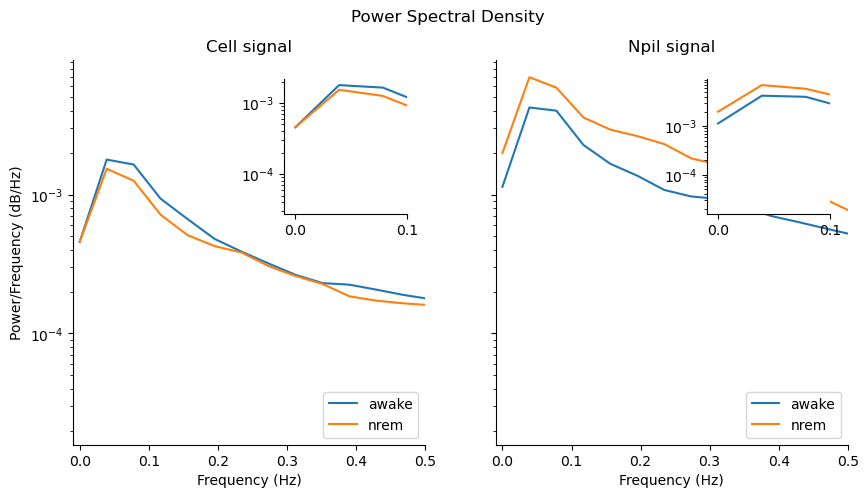

In [21]:
# Create the main semilogy
fig, ax = plt.subplots(ncols=2, figsize=(10, 5), sharey=True)
fig.suptitle("Power Spectral Density")
freq = cell_df.loc["cell_awake_freq"][0]["freq"]

ax[0].semilogy(freq, cell_awake_mean_freq, label="awake")
ax[0].semilogy(freq, cell_nrem_mean_freq, label="nrem")
ax[0].legend(loc="lower right")
ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)
ax[0].set_title("Cell signal")
ax[0].set_xlabel("Frequency (Hz)")
ax[0].set_ylabel("Power/Frequency (dB/Hz)")
ax[0].set_xlim(-0.01, 0.5)

# Define the bounds of the inset as (x, y, width, height) using figure-relative coordinates
bounds = [0.6, 0.6, 0.35, 0.35]

# Create an inset
axins1 = ax[0].inset_axes(bounds=bounds)
axins1.spines["top"].set_visible(False)
axins1.spines["right"].set_visible(False)

# semilogy data in the inset
axins1.semilogy(freq, cell_awake_mean_freq, label="awake")
axins1.semilogy(freq, cell_nrem_mean_freq, label="nrem")

# Adjust the inset's position and axes limits
axins1.set_xlim(-0.01, 0.1)  # Modify these values to specify the desired limits
# axins1.set_ylim(0, 7000)  # Modify these values to specify the desired limits

ax[1].semilogy(freq, npil_awake_mean_freq, label="awake")
ax[1].semilogy(freq, npil_nrem_mean_freq, label="nrem")
ax[1].set_title("Npil signal")
ax[1].set_xlabel("Frequency (Hz)")
ax[1].legend(loc="lower right")
ax[1].spines["top"].set_visible(False)
ax[1].spines["right"].set_visible(False)
ax[1].set_xlim(-0.01, 0.5)

# Define the bounds of the inset as (x, y, width, height) using figure-relative coordinates
bounds = [0.6, 0.6, 0.35, 0.35]

# Create an inset
axins2 = ax[1].inset_axes(bounds=bounds)
axins2.spines["top"].set_visible(False)
axins2.spines["right"].set_visible(False)

# semilogy data in the inset
axins2.semilogy(freq, npil_awake_mean_freq, label="awake")
axins2.semilogy(freq, npil_nrem_mean_freq, label="nrem")

# Adjust the inset's position and axes limits
axins2.set_xlim(-0.01, 0.1)  # Modify these values to specify the desired limits
# axins2.set_ylim(0, 3000)  # Modify these values to specify the desired limits

plt.show()